# いろいろ実装

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchsummary import summary
from visdom import Visdom

import medmnist
from medmnist import INFO, Evaluator

## 可視化

In [3]:
from medmnist import PathMNIST
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# 学習用前処理
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
# データセットの作成（学習用）
train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

# 可視化用前処理
visual_transform = transforms.Compose([
    transforms.ToTensor()  # Normalizeは不要
])
# データセットの作成（可視化用）
visual_data = medmnist.PathMNIST(split='train', transform=visual_transform, download=True)

Using downloaded and verified file: /home/jovyan/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/jovyan/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/jovyan/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/jovyan/.medmnist/pathmnist.npz


In [4]:
print(train_data)
print("===================")
print(val_data)
print("===================")
print(test_data)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/jovyan/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-

In [5]:
# クラス名の辞書
class_labels = {
    0: '脂肪組織',
    1: '背景',
    2: '破片',
    3: 'リンパ球',
    4: '粘液',
    5: '平滑筋',
    6: '正常な結腸粘膜',
    7: '癌関連間質',
    8: '結腸直腸腺癌上皮'
}
class_labels

{0: '脂肪組織',
 1: '背景',
 2: '破片',
 3: 'リンパ球',
 4: '粘液',
 5: '平滑筋',
 6: '正常な結腸粘膜',
 7: '癌関連間質',
 8: '結腸直腸腺癌上皮'}

In [6]:
from collections import Counter

# 全ラベルを収集
all_labels = [int(label.item()) for _, label in visual_data]

# クラス分布をカウント
label_counts = Counter(all_labels)

# クラス名と枚数をリスト化
class_labels_list = [class_labels[class_id] for class_id in label_counts.keys()]
counts = list(label_counts.values())

# 分布を表示
for class_name, count in zip(class_labels_list, counts):
    print(f"{class_name}: {count} 枚")

脂肪組織: 9366 枚
粘液: 8006 枚
癌関連間質: 9401 枚
平滑筋: 12182 枚
結腸直腸腺癌上皮: 12885 枚
リンパ球: 10401 枚
破片: 10360 枚
背景: 9509 枚
正常な結腸粘膜: 7886 枚


- クラス名を取得
    - label_counts.keys() は label_counts （Counter オブジェクト）のキー（クラスIDのリスト）を取得します。
    - リスト内包表記 [... for ... in ...] を使用して、クラスIDに対応するクラス名を class_labels から取り出し、新しいリスト class_labels_list を作成します。
- 枚数を取得
    - label_counts.values() は、label_counts （Counter オブジェクト）の値（各クラスのカウント）を取得します。
    - これを list() によってリストに変換し、新しいリスト counts を作成します。

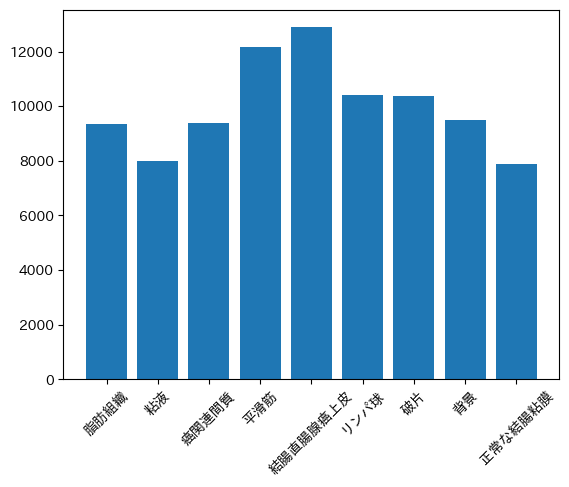

In [7]:
plt.bar(class_labels_list, counts)
plt.xticks(rotation=45)
plt.show()

In [8]:
# classIDに対応する画像を収集する
class_images = {} # クラスIDをキー、画像データを値とする辞書
for image, label in visual_data:
    class_id = int(label.item() if hasattr(label, "item") else label[0]) # クラスIDを取得
    if class_id not in class_images: # クラスごとに1枚の画像を収集
        class_images[class_id] = image
    if len(class_images) == len(class_labels): # 全クラス分が集まったら終了
        break

- hasattr
Pythonの組み込み関数で、オブジェクトが特定の属性を持っているかを確認する
属性が存在する場合にTrue, 存在しない場合にFlaseを返す
hasattr(object, name)で使う（objectに属性を調べたい対象のオブジェクト、nameにチェックしたい属性名を入れる）
今回はlabelがitemというメソッドを持っているかどうかを確認する
Trueの場合はlabel.item()を実行し、スカラー値を取得、Falseの場合はlabel[0]を実行して配列の最初の要素を取得する
★label の型ごとの可能性
1. PyTorch テンソルの場合 (torch.Tensor)
label.item() が有効で、スカラー値を取得可能。
item() メソッドを持っている。
2. NumPy 配列の場合 (numpy.ndarray)
label.item() が有効。ただし、1要素しかない場合にのみスカラー値を取得可能。
item() メソッドを持っている。
3. 混在している場合（テンソルやリストなど）
型が混在しているなら、if hasattr(label, "item") を使って処理を分岐するのが安全。
→今回はif文の分岐は不要だが一応記載

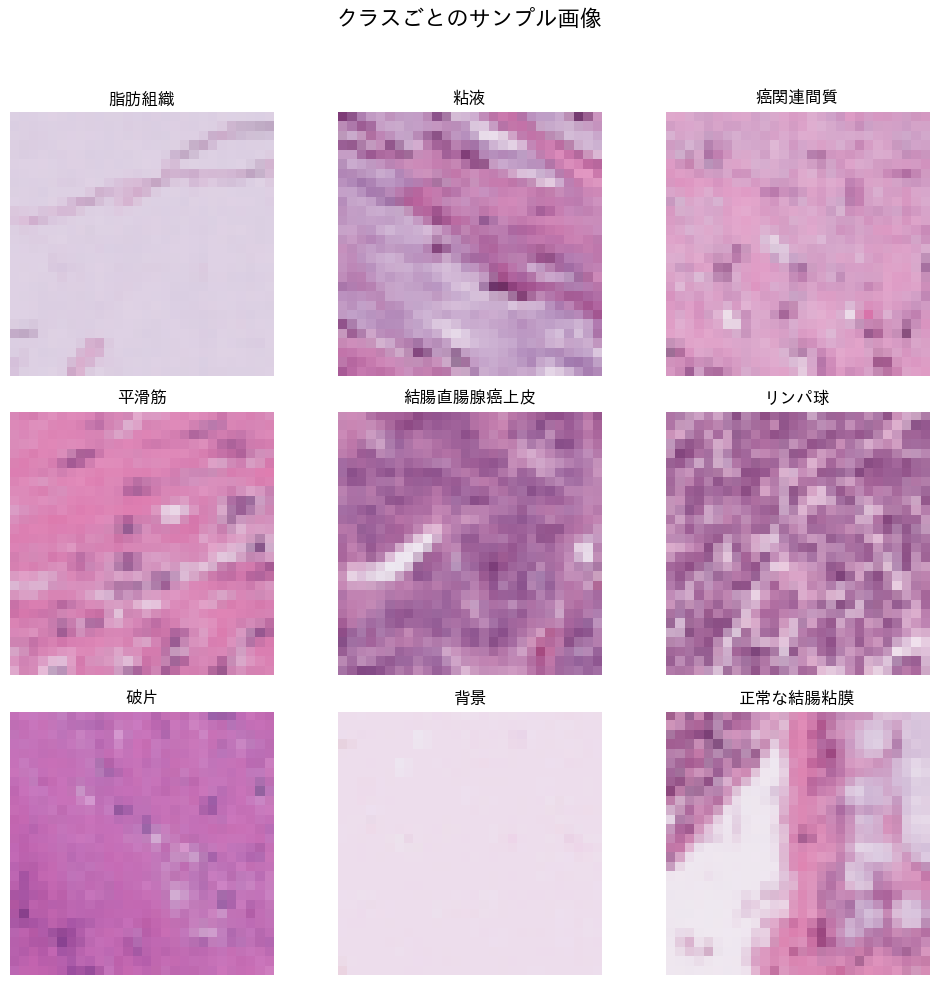

In [9]:
# 3×3のグリッドで画像を表示
fig, axes = plt.subplots(3,3,figsize=(10,10))
fig.suptitle("クラスごとのサンプル画像", fontsize=16)

# 各クラスの画像をプロット
# axes.rabel()で 9 個のプロット領域を平坦化し、ループで各画像を埋め込む
for ax, (class_id, image) in zip(axes.ravel(), class_images.items()):
    # 画像をプロット
    ax.imshow(image.permute(1,2,0).numpy()) # matplotlib の imshow が期待する形式に変換
    ax.set_title(class_labels[class_id])
    ax.axis("off")
plt.tight_layout(rect=[0,0,1,0.95]) 
# tight_layout(): プロット内の要素が重ならないように自動調整するもの。
# rect = [左端の割合, 下端の割合, 右端の割合, 上端の割合]で、プロット全体の表示領域を図の左端・下端から右端・上端まで調整し、上端に余白（5%分）を確保する設定
plt.show()

## 学習用に前処理を行う

In [10]:
from torch.utils.data import DataLoader

# データローダーに変換
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}") 
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [12]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa98c1d6710>, <torch.utils.data.dataloader.DataLoader object at 0x7fa98c353410>)
Length of train dataloader: 704 batches of 128
Length of test dataloader: 57 batches of 128
Length of val dataloader: 79 batches of 128


In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 3, 28, 28]), torch.Size([128, 1]))

## 使わない

In [108]:
NUM_EPOCHS = 5
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [109]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [112]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_dataloader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [01:01<00:00, 11.43it/s]


In [137]:
#  Evaluation
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = val_dataloader if split == 'train' else test_dataloader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

In [118]:
net = Net(3, 9).to()
summary(net, (3, 28, 28))  # GPUを使わない場合、引数のdeviceをcpuに変更

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             448
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,320
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 64, 10, 10]           9,280
       BatchNorm2d-9           [-1, 64, 10, 10]             128
             ReLU-10           [-1, 64, 10, 10]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [139]:
# Visdom インスタンス作成
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs =30
# 空リストの用意
train_loss_list = []
train_acc_list  = []
test_loss_list = []
test_acc_list  = []

# 30回エポックを繰り返す
for epoch in range(n_epochs):
    train_loss = 0
    train_acc  = 0
    test_loss = 0
    test_acc  = 0

    model.train()  # 学習モードに切り替え
    
    for i, (imgs, labels) in enumerate(train_dataloader):
        imgs   = imgs.to(device)
        labels = labels.to(device).squeeze()  # ラベルの形状を調整
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        
        # ロスと正解率の更新
        train_loss += loss.item()
        train_acc  += (outputs.max(1)[1] == labels).sum().item()
        
        loss.backward()  # 逆伝搬
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc  = train_acc  / len(train_dataloader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs   = imgs.to(device)
            labels = labels.to(device).squeeze()  # ラベルの形状を調整
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += (outputs.max(1)[1] == labels).sum().item()
            
        avg_test_loss = test_loss / len(val_dataloader.dataset)
        avg_test_acc  = test_acc / len(val_dataloader.dataset)

    # Visdom 可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win='loss', name='avg_train_loss', update='append',
             opts={'title': 'Loss', 'xlabel': 'Epoch', 'ylabel': 'Loss'})
    
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win='acc', name='avg_train_acc', update='append',
             opts={'title': 'Accuracy', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})
    viz.line(X=np.array([epoch]), Y=np.array([avg_test_loss]),
             win='loss', name='avg_test_loss', update='append')
    viz.line(X=np.array([epoch]), Y=np.array([avg_test_acc]),
             win='acc', name='avg_test_acc', update='append')
    
    print('epoch: {}, train_loss: {:.3f}, train_acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'
          .format(epoch, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc))
    
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(avg_test_acc)

Setting up a new session...


epoch: 0, train_loss: 0.000, train_acc: 0.990, val_loss: 0.002, val_acc: 0.923
epoch: 1, train_loss: 0.000, train_acc: 0.989, val_loss: 0.002, val_acc: 0.945
epoch: 2, train_loss: 0.000, train_acc: 0.991, val_loss: 0.001, val_acc: 0.948
epoch: 3, train_loss: 0.000, train_acc: 0.993, val_loss: 0.002, val_acc: 0.936
epoch: 4, train_loss: 0.000, train_acc: 0.992, val_loss: 0.002, val_acc: 0.939
epoch: 5, train_loss: 0.000, train_acc: 0.994, val_loss: 0.002, val_acc: 0.940
epoch: 6, train_loss: 0.000, train_acc: 0.993, val_loss: 0.002, val_acc: 0.944
epoch: 7, train_loss: 0.000, train_acc: 0.993, val_loss: 0.002, val_acc: 0.935
epoch: 8, train_loss: 0.000, train_acc: 0.992, val_loss: 0.002, val_acc: 0.942
epoch: 9, train_loss: 0.000, train_acc: 0.994, val_loss: 0.002, val_acc: 0.923
epoch: 10, train_loss: 0.000, train_acc: 0.990, val_loss: 0.002, val_acc: 0.942
epoch: 11, train_loss: 0.000, train_acc: 0.993, val_loss: 0.002, val_acc: 0.943
epoch: 12, train_loss: 0.000, train_acc: 0.994, va

In [132]:
viz = Visdom(server="http://host.docker.internal", port=8097)
# 127.0.0.1（localhost）は、コンテナ内のローカル環境を指す
# Docker コンテナからホストマシンにアクセスするには、ホストを host.docker.internal に設定

if not viz.check_connection():
    print("Visdom サーバーに接続できません。以下を確認してください：")
    print("- Visdom サーバーが起動しているか")
    print("- 正しいポート（デフォルトは 8097）を使用しているか")
    print("- ファイアウォールやネットワーク設定が正しいか")
    exit(1)
else:
    print("Visdom サーバーに正常に接続されました。")

Setting up a new session...


Visdom サーバーに正常に接続されました。


1. モデル学習（train データを使用）
train データを使用してモデルの重みを更新する。
ミニバッチを使用して学習を進める。
2. ハイパーパラメータの調整（val データを使用）
各エポックごとに val データでモデルを評価し、損失や正解率を記録。
学習率やエポック数を調整して過学習を防ぐ。
3. 最終的なモデル評価（test データを使用）
学習と検証が終了したら、test データでモデルの最終的な性能（正解率や損失）を測定。
この段階では train や val データには触れない。

ステップ 1: 基本的なCNNモデルの構築
まずは、基本的なCNN構造を実装して性能を測定します。
ステップ 2: モデルの性能を評価
上記の基本構造を使用し、訓練 (train) と検証 (val) データでモデルを学習・評価します。
検証データでの損失や正解率を記録します。
ステップ 3: 層構造の変更を試す
次に、CNNの層構造を変更し、検証データでモデルの性能を比較します。以下は、試行錯誤できる具体例です。
1. 畳み込み層の変更
畳み込み層のフィルタ数を変更。
カーネルサイズ（kernel_size）を変更。
ストライド（stride）を調整。
2. プーリング層の種類を変更
MaxPool を AvgPool（平均プーリング）に変更。
プーリングサイズを調整。
3. 活性化関数を変更
ReLU を LeakyReLU や ELU などに変更。
4. ドロップアウトの追加
ドロップアウトを加えて過学習を防止。
5. バッチ正規化の追加
畳み込み層の後にバッチ正規化を加えることで、学習を安定させる。
ステップ 4: 検証データでの性能比較
各変更ごとに、検証データで損失や正解率を記録し、どの構造が最も良い結果を出すかを比較します。
3. 注意点
検証データのみに依存しすぎない

層構造を調整する際に検証データを使いますが、test データは最終的な性能評価のために取っておきます。
層構造の調整と過学習のトレードオフ

より複雑な層構造は訓練データでの精度を向上させる可能性がありますが、検証データでの性能が向上しない場合、過学習の可能性があります。
試行錯誤を記録

試した層構造とその結果を記録することで、最適な構造を見つけやすくなります。

## ベースラインモデルを作成

1. LeNet-5
- 特徴:
非常にシンプルなCNNモデル。
MNISTのような手書き数字認識で開発された、畳み込みニューラルネットワークの基本形。
計算コストが低く、MNISTやCIFAR-10のような小規模なデータセットに適している。
- 構造:
畳み込み層 × 2
プーリング層 × 2
全結合層 × 2

<center><img src="./imgs/LeNet-1024x544.png" width=400px></center>

- 活性化関数には，これまで定番だったシグモイド関数の代わりに，彼らが使用を提案したtanh関数が主に使用されている．近年のCNN隠れ層の活性化関数はReLU [Nair and Hinton, 2010] 系の関数が定番であるが，LeNetの時点ではそもそもReLUが登場していない．
- 出力層は，まだsoftmax関数層ではなく，RBF(Radial Basis Function)である．
当時使用された活性化関数
tanh（双曲線正接関数）

出力範囲: 
[−1,1][−1,1]
非線形性を導入するために使われ、学習の安定性を提供していました。
ただし、勾配消失問題（gradient vanishing problem）が発生しやすい。
ガウス関数（Gaussian Activation Function）

主に特定のアーキテクチャで用いられることがあり、計算が複雑なため現在ではほとんど使用されていません。

- ベースラインとして性能を確かめるので、以下は初期設定から変えたい。

**構成**
- 畳み込み層conv1：カーネルサイズ5×5、ストライド1、パディング0
    - 入力28×28→出力24×24×6
- プーディングpool1：カーネルサイズ2×2、ストライド2
    - 入力24×24→出力12×12
- 畳み込み層cov2：カーネルサイズ5×5、ストライド1、パディング0
    - 入力12×12→出力8×8×16
- プーディングpool2：カーネルサイズ2×2、ストライド2
    - 入力8×8→出力4×4×16

In [14]:
n_epochs = 30
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [18]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # 特徴マップをフラット化
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5(in_channels=n_channels, num_classes=n_classes)
    
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [19]:
# Visdom インスタンス作成
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 空リストの用意
train_loss_list = []
train_acc_list  = []
val_loss_list = []
val_acc_list  = []

best_val_loss = float('inf')
stopping_counter = 0

# 30回エポックを繰り返す
for epoch in range(n_epochs):
    train_loss = 0
    train_acc  = 0
    val_loss = 0
    val_acc  = 0

    model.train()  # 学習モードに切り替え
    
    for i, (imgs, labels) in enumerate(train_dataloader):
        imgs   = imgs.to(device)
        labels = labels.to(device).squeeze()  # ラベルの形状を調整
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        
        # ロスと正解率の更新
        train_loss += loss.item()
        train_acc  += (outputs.max(1)[1] == labels).sum().item()
        
        loss.backward()  # 逆伝搬
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc  = train_acc  / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs   = imgs.to(device)
            labels = labels.to(device).squeeze()  # ラベルの形状を調整
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
            
        avg_val_loss = val_loss / len(val_dataloader.dataset)
        avg_val_acc  = val_acc / len(val_dataloader.dataset)

    # Visdom 可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win='loss', name='avg_train_loss', update='append',
             opts={'title': 'Loss', 'xlabel': 'Epoch', 'ylabel': 'Loss'})
    
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win='acc', name='avg_train_acc', update='append',
             opts={'title': 'Accuracy', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})
    
    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win='loss', name='avg_val_loss', update='append')
    
    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win='acc', name='avg_val_acc', update='append')
    
    print(f'Epoch {epoch+1}, Train Loss:{avg_train_loss:.3f}, Train Acc:{avg_train_acc:.3f}')
    print(f'Val loss:{avg_val_loss:.3f}, Val Acc:{avg_val_acc:.3f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        stopping_counter = 0
    else:
        stopping_counter += 1
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Setting up a new session...


Epoch 1, Train Loss:0.017, Train Acc:0.138
Val loss:0.017, Val Acc:0.194
Epoch 2, Train Loss:0.016, Train Acc:0.220
Val loss:0.016, Val Acc:0.236
Epoch 3, Train Loss:0.014, Train Acc:0.296
Val loss:0.013, Val Acc:0.356
Epoch 4, Train Loss:0.013, Train Acc:0.378
Val loss:0.012, Val Acc:0.418
Epoch 5, Train Loss:0.011, Train Acc:0.428
Val loss:0.011, Val Acc:0.432
Epoch 6, Train Loss:0.010, Train Acc:0.533
Val loss:0.009, Val Acc:0.541
Epoch 7, Train Loss:0.009, Train Acc:0.580
Val loss:0.008, Val Acc:0.593
Epoch 8, Train Loss:0.008, Train Acc:0.596
Val loss:0.010, Val Acc:0.512
Epoch 9, Train Loss:0.008, Train Acc:0.607
Val loss:0.008, Val Acc:0.625
Epoch 10, Train Loss:0.008, Train Acc:0.624
Val loss:0.008, Val Acc:0.632
Epoch 11, Train Loss:0.007, Train Acc:0.648
Val loss:0.009, Val Acc:0.593
Epoch 12, Train Loss:0.007, Train Acc:0.666
Val loss:0.008, Val Acc:0.634
Epoch 13, Train Loss:0.007, Train Acc:0.675
Val loss:0.007, Val Acc:0.678
Epoch 14, Train Loss:0.007, Train Acc:0.684
Val

<left><img src="./imgs/ベースライン_epoch30.png" width=600px></left>

- epochが足りなかったかもしれないので今度は40回で実装してみる
- 今のところ過学習は見られない
- また、シード値を設定し忘れていたので、やり直し。。

## 試行1：ベースライン（やり直し）

In [15]:
import random
# 再現性のためにランダムシードを設定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)  # 任意のシード値

In [16]:
n_epochs = 40
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [53]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # 特徴マップをフラット化
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "LeNet5"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

LeNet5


In [54]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0171, Train Acc: 0.1345
Val Loss: 0.0169, Val Acc: 0.2340
Best model saved for LeNet5 at Epoch 1
Epoch 2, Train Loss: 0.0142, Train Acc: 0.3159
Val Loss: 0.0131, Val Acc: 0.3482
Best model saved for LeNet5 at Epoch 2
Epoch 3, Train Loss: 0.0125, Train Acc: 0.3804
Val Loss: 0.0122, Val Acc: 0.3953
Best model saved for LeNet5 at Epoch 3
Epoch 4, Train Loss: 0.0114, Train Acc: 0.4272
Val Loss: 0.0107, Val Acc: 0.4443
Best model saved for LeNet5 at Epoch 4
Epoch 5, Train Loss: 0.0097, Train Acc: 0.5255
Val Loss: 0.0100, Val Acc: 0.4996
Best model saved for LeNet5 at Epoch 5
Epoch 6, Train Loss: 0.0088, Train Acc: 0.5644
Val Loss: 0.0088, Val Acc: 0.5549
Best model saved for LeNet5 at Epoch 6
Epoch 7, Train Loss: 0.0086, Train Acc: 0.5746
Val Loss: 0.0091, Val Acc: 0.5446
No improvement. Early stopping counter: 1/5
Epoch 8, Train Loss: 0.0083, Train Acc: 0.5891
Val Loss: 0.0081, Val Acc: 0.6051
Best model saved for LeNet5 at Epoch 8
Epoch 9, Train Loss: 0.0080, Train 

## smallVGG

In [55]:
n_epochs = 40
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [56]:
class SmallVGG(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG


In [57]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0169, Train Acc: 0.1690
Val Loss: 0.0163, Val Acc: 0.2333
Best model saved for SmallVGG at Epoch 1
Epoch 2, Train Loss: 0.0137, Train Acc: 0.3311
Val Loss: 0.0125, Val Acc: 0.3896
Best model saved for SmallVGG at Epoch 2
Epoch 3, Train Loss: 0.0110, Train Acc: 0.4472
Val Loss: 0.0114, Val Acc: 0.4280
Best model saved for SmallVGG at Epoch 3
Epoch 4, Train Loss: 0.0088, Train Acc: 0.5690
Val Loss: 0.0080, Val Acc: 0.6037
Best model saved for SmallVGG at Epoch 4
Epoch 5, Train Loss: 0.0082, Train Acc: 0.5985
Val Loss: 0.0085, Val Acc: 0.5802
No improvement. Early stopping counter: 1/5
Epoch 6, Train Loss: 0.0077, Train Acc: 0.6204
Val Loss: 0.0074, Val Acc: 0.6343
Best model saved for SmallVGG at Epoch 6
Epoch 7, Train Loss: 0.0075, Train Acc: 0.6327
Val Loss: 0.0070, Val Acc: 0.6592
Best model saved for SmallVGG at Epoch 7
Epoch 8, Train Loss: 0.0072, Train Acc: 0.6502
Val Loss: 0.0067, Val Acc: 0.6736
Best model saved for SmallVGG at Epoch 8
Epoch 9, Train Loss: 

## 試行3：smallVGG + Batch Normalization を追加

- 目的
学習の安定性を向上し、収束を速める
- 変更点
各畳み込み層の後にBatchNorm2dを追加

In [65]:
class SmallVGG_bn(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_bn, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_bn(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_bn"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG_bn


In [66]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0067, Train Acc: 0.6891
Val Loss: 0.0051, Val Acc: 0.7607
Best model saved for SmallVGG_bn at Epoch 1
Epoch 2, Train Loss: 0.0038, Train Acc: 0.8275
Val Loss: 0.0055, Val Acc: 0.7675
No improvement. Early stopping counter: 1/5
Epoch 3, Train Loss: 0.0029, Train Acc: 0.8701
Val Loss: 0.0024, Val Acc: 0.8897
Best model saved for SmallVGG_bn at Epoch 3
Epoch 4, Train Loss: 0.0024, Train Acc: 0.8945
Val Loss: 0.0025, Val Acc: 0.8894
No improvement. Early stopping counter: 1/5
Epoch 5, Train Loss: 0.0020, Train Acc: 0.9105
Val Loss: 0.0024, Val Acc: 0.8880
Best model saved for SmallVGG_bn at Epoch 5
Epoch 6, Train Loss: 0.0018, Train Acc: 0.9228
Val Loss: 0.0017, Val Acc: 0.9222
Best model saved for SmallVGG_bn at Epoch 6
Epoch 7, Train Loss: 0.0016, Train Acc: 0.9279
Val Loss: 0.0023, Val Acc: 0.8952
No improvement. Early stopping counter: 1/5
Epoch 8, Train Loss: 0.0015, Train Acc: 0.9364
Val Loss: 0.0014, Val Acc: 0.9406
Best model saved for SmallVGG_bn at Epoch 8


## 試行4：smallVGG + Dropout を畳み込みブロック後に追加

- 目的
過学習を抑制し、汎化性能を向上
- 変更点
各畳み込みブロックの後に Dropout を追加

In [17]:
class SmallVGG_do(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_do, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(0.3),  # 過学習防止

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout(0.3)  # 過学習防止
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_do(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_do"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG_do


In [18]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0171, Train Acc: 0.1419
Val Loss: 0.0170, Val Acc: 0.1612
Best model saved for SmallVGG_do at Epoch 1
Epoch 2, Train Loss: 0.0140, Train Acc: 0.3213
Val Loss: 0.0115, Val Acc: 0.3970
Best model saved for SmallVGG_do at Epoch 2
Epoch 3, Train Loss: 0.0100, Train Acc: 0.5011
Val Loss: 0.0088, Val Acc: 0.5701
Best model saved for SmallVGG_do at Epoch 3
Epoch 4, Train Loss: 0.0087, Train Acc: 0.5726
Val Loss: 0.0080, Val Acc: 0.6054
Best model saved for SmallVGG_do at Epoch 4
Epoch 5, Train Loss: 0.0081, Train Acc: 0.6009
Val Loss: 0.0076, Val Acc: 0.6191
Best model saved for SmallVGG_do at Epoch 5
Epoch 6, Train Loss: 0.0077, Train Acc: 0.6179
Val Loss: 0.0082, Val Acc: 0.6022
No improvement. Early stopping counter: 1/5
Epoch 7, Train Loss: 0.0074, Train Acc: 0.6336
Val Loss: 0.0070, Val Acc: 0.6628
Best model saved for SmallVGG_do at Epoch 7
Epoch 8, Train Loss: 0.0070, Train Acc: 0.6545
Val Loss: 0.0068, Val Acc: 0.6665
Best model saved for SmallVGG_do at Epoch 8


NameError: name 'all_model_results' is not defined

In [19]:
all_model_results = []  # 全体のベストモデルを記録するリスト
# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

In [20]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_do
Val Loss: 0.0021
Model path: best_model_SmallVGG_do.pth
Test Loss: 0.0053, Test Accuracy: 0.8322


## 試行5：smallVGG＋3ブロック＋ 各ブロック後に BatchNorm2d とDropoutとを追加

- 目的
特徴抽出能力をさらに向上させつつ、正則化を強化
- 変更点
    - 畳み込みブロックを3つに拡張。
    - 各畳み込み層の後に BatchNorm2d を追加。
    - 各ブロック後に Dropout を追加

In [21]:
class SmallVGG_3blocks(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_3blocks, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(0.3), # 過学習防止

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout(0.3), # 過学習防止

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # 正規化
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7x7 -> 3x3
            nn.Dropout(0.3) # 過学習防止
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_3blocks"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG_3blocks


In [22]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0081, Train Acc: 0.6172
Val Loss: 0.0067, Val Acc: 0.6802
Best model saved for SmallVGG_3blocks at Epoch 1
Epoch 2, Train Loss: 0.0046, Train Acc: 0.7885
Val Loss: 0.0069, Val Acc: 0.6925
No improvement. Early stopping counter: 1/5
Epoch 3, Train Loss: 0.0036, Train Acc: 0.8346
Val Loss: 0.0031, Val Acc: 0.8578
Best model saved for SmallVGG_3blocks at Epoch 3
Epoch 4, Train Loss: 0.0031, Train Acc: 0.8621
Val Loss: 0.0028, Val Acc: 0.8741
Best model saved for SmallVGG_3blocks at Epoch 4
Epoch 5, Train Loss: 0.0027, Train Acc: 0.8805
Val Loss: 0.0024, Val Acc: 0.8968
Best model saved for SmallVGG_3blocks at Epoch 5
Epoch 6, Train Loss: 0.0024, Train Acc: 0.8951
Val Loss: 0.0034, Val Acc: 0.8467
No improvement. Early stopping counter: 1/5
Epoch 7, Train Loss: 0.0022, Train Acc: 0.9046
Val Loss: 0.0023, Val Acc: 0.8984
Best model saved for SmallVGG_3blocks at Epoch 7
Epoch 8, Train Loss: 0.0020, Train Acc: 0.9119
Val Loss: 0.0049, Val Acc: 0.8157
No improvement. Ear

In [23]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_3blocks
Val Loss: 0.0007
Model path: best_model_SmallVGG_3blocks.pth
Test Loss: 0.0055, Test Accuracy: 0.8075


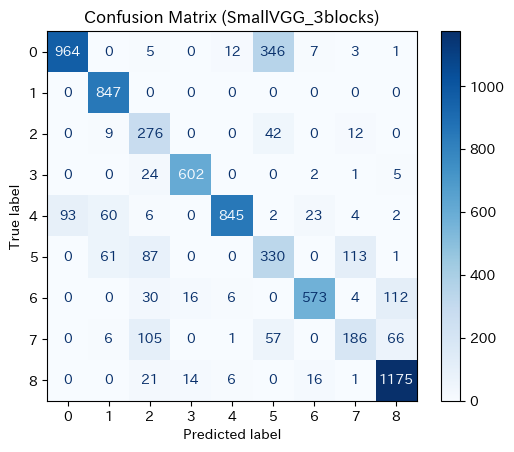

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
#model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
#model.load_state_dict(torch.load(best_model_path))
#model.to(device)
#model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9990
Test AUC: 0.9706


## 試行6：smallVGG + smallVGG＋3ブロック＋ 各ブロック後に BatchNorm2d とDropoutとを追加＋学習率スケジュール

In [27]:
n_epochs = 40
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [28]:
from torch.optim.lr_scheduler import StepLR

In [29]:
class SmallVGG_3blocks_lr(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_3blocks_lr, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(0.3), # 過学習防止

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout(0.3), # 過学習防止

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # 正規化
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7x7 -> 3x3
            nn.Dropout(0.3) # 過学習防止
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_3blocks_lr(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_3blocks_lr"
best_model_path = f"best_model_{model.experiment_name}.pth"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# スケジューラを定義
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # 5エポックごとに学習率を半分に
# 初期学習率を表示
print(f"Initial LR: {scheduler.get_last_lr()[0]:.6f}")

SmallVGG_3blocks_lr
Initial LR: 0.001000


In [30]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデルの保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at Epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break
            
    # スケジューラで学習率を更新
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}, Current LR: {current_lr:.6f}")

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    
# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0082, Train Acc: 0.6037
Val Loss: 0.0073, Val Acc: 0.6489
Best model saved at Epoch 1 with Val Loss: 0.0073
Epoch 1, Current LR: 0.001000
Epoch 2, Train Loss: 0.0048, Train Acc: 0.7758
Val Loss: 0.0044, Val Acc: 0.7933
Best model saved at Epoch 2 with Val Loss: 0.0044
Epoch 2, Current LR: 0.001000
Epoch 3, Train Loss: 0.0038, Train Acc: 0.8288
Val Loss: 0.0050, Val Acc: 0.7952
No improvement. Early stopping counter: 1/5
Epoch 3, Current LR: 0.001000
Epoch 4, Train Loss: 0.0031, Train Acc: 0.8610
Val Loss: 0.0059, Val Acc: 0.7666
No improvement. Early stopping counter: 2/5
Epoch 4, Current LR: 0.001000
Epoch 5, Train Loss: 0.0027, Train Acc: 0.8802
Val Loss: 0.0018, Val Acc: 0.9237
Best model saved at Epoch 5 with Val Loss: 0.0018
Epoch 5, Current LR: 0.000500
Epoch 6, Train Loss: 0.0023, Train Acc: 0.9004
Val Loss: 0.0025, Val Acc: 0.8909
No improvement. Early stopping counter: 1/5
Epoch 6, Current LR: 0.000500
Epoch 7, Train Loss: 0.0021, Train Acc: 0.9063
Val L

In [31]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_3blocks_lr
Val Loss: 0.0013
Model path: best_model_SmallVGG_3blocks_lr.pth
Test Loss: 0.0069, Test Accuracy: 0.7354


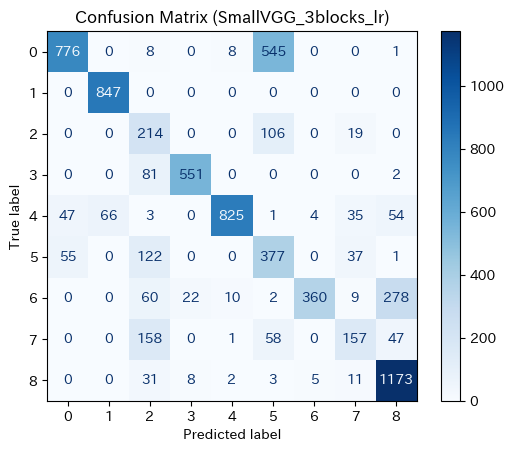

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
# model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
# model.load_state_dict(torch.load(best_model_path))
# model.to(device)
# model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9977
Test AUC: 0.9593


## 試行7 試行6+dropoutの割合を変えてみる

In [34]:
n_epochs = 40
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [35]:
from torch.optim.lr_scheduler import StepLR

In [36]:
class SmallVGG_3blocks_lr_do05(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_3blocks_lr_do05, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(0.5), # 過学習防止(0.5)

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout(0.5), # 過学習防止(0.5)

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # 正規化
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7x7 -> 3x3
            nn.Dropout(0.5) # 過学習防止(0.5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_3blocks_lr_do05(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_3blocks_lr_do05"
best_model_path = f"best_model_{model.experiment_name}.pth"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# スケジューラを定義
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # 5エポックごとに学習率を半分に
# 初期学習率を表示
print(f"Initial LR: {scheduler.get_last_lr()[0]:.6f}")

SmallVGG_3blocks_lr_do05
Initial LR: 0.001000


In [37]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデルの保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at Epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break
            
    # スケジューラで学習率を更新
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}, Current LR: {current_lr:.6f}")

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    
# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0097, Train Acc: 0.5320
Val Loss: 0.0126, Val Acc: 0.4779
Best model saved at Epoch 1 with Val Loss: 0.0126
Epoch 1, Current LR: 0.001000
Epoch 2, Train Loss: 0.0062, Train Acc: 0.7061
Val Loss: 0.0109, Val Acc: 0.6135
Best model saved at Epoch 2 with Val Loss: 0.0109
Epoch 2, Current LR: 0.001000
Epoch 3, Train Loss: 0.0051, Train Acc: 0.7665
Val Loss: 0.0177, Val Acc: 0.5203
No improvement. Early stopping counter: 1/5
Epoch 3, Current LR: 0.001000
Epoch 4, Train Loss: 0.0043, Train Acc: 0.8030
Val Loss: 0.0054, Val Acc: 0.7679
Best model saved at Epoch 4 with Val Loss: 0.0054
Epoch 4, Current LR: 0.001000
Epoch 5, Train Loss: 0.0039, Train Acc: 0.8239
Val Loss: 0.0177, Val Acc: 0.5429
No improvement. Early stopping counter: 1/5
Epoch 5, Current LR: 0.000500
Epoch 6, Train Loss: 0.0034, Train Acc: 0.8456
Val Loss: 0.0067, Val Acc: 0.7541
No improvement. Early stopping counter: 2/5
Epoch 6, Current LR: 0.000500
Epoch 7, Train Loss: 0.0032, Train Acc: 0.8532
Val L

In [38]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_3blocks_lr_do05
Val Loss: 0.0029
Model path: best_model_SmallVGG_3blocks_lr_do05.pth
Test Loss: 0.0139, Test Accuracy: 0.5918


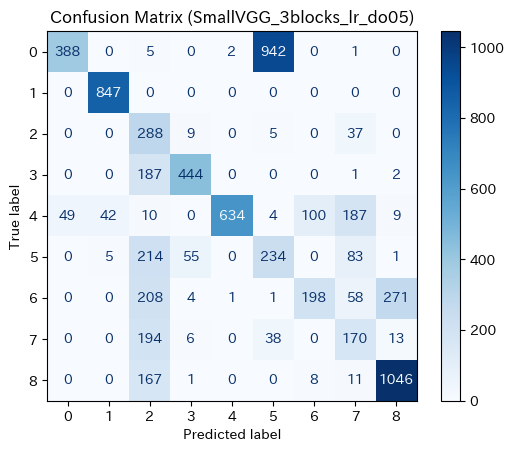

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
# model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
# model.load_state_dict(torch.load(best_model_path))
# model.to(device)
# model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9910
Test AUC: 0.9288


In [41]:
best_overall_model

{'model_name': 'SmallVGG_3blocks_lr_do05',
 'val_loss': 0.0029493198275375443,
 'file_path': 'best_model_SmallVGG_3blocks_lr_do05.pth'}

## 試行8：smallVGG + Batch Normalization を追加＋全結合層のdropoutを0.4に弱める

In [43]:
class SmallVGG_bn_do04(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_bn_do04, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.4), # 0.4にする
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_bn_do04(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_bn_do04"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG_bn_do04


In [44]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0065, Train Acc: 0.6953
Val Loss: 0.0057, Val Acc: 0.7440
Best model saved for SmallVGG_bn_do04 at Epoch 1
Epoch 2, Train Loss: 0.0039, Train Acc: 0.8232
Val Loss: 0.0040, Val Acc: 0.8193
Best model saved for SmallVGG_bn_do04 at Epoch 2
Epoch 3, Train Loss: 0.0029, Train Acc: 0.8694
Val Loss: 0.0058, Val Acc: 0.7682
No improvement. Early stopping counter: 1/5
Epoch 4, Train Loss: 0.0023, Train Acc: 0.8962
Val Loss: 0.0024, Val Acc: 0.8972
Best model saved for SmallVGG_bn_do04 at Epoch 4
Epoch 5, Train Loss: 0.0020, Train Acc: 0.9126
Val Loss: 0.0047, Val Acc: 0.7884
No improvement. Early stopping counter: 1/5
Epoch 6, Train Loss: 0.0018, Train Acc: 0.9201
Val Loss: 0.0015, Val Acc: 0.9335
Best model saved for SmallVGG_bn_do04 at Epoch 6
Epoch 7, Train Loss: 0.0015, Train Acc: 0.9336
Val Loss: 0.0019, Val Acc: 0.9167
No improvement. Early stopping counter: 1/5
Epoch 8, Train Loss: 0.0013, Train Acc: 0.9412
Val Loss: 0.0014, Val Acc: 0.9363
Best model saved for Sma

In [45]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_bn_do04
Val Loss: 0.0009
Model path: best_model_SmallVGG_bn_do04.pth
Test Loss: 0.0053, Test Accuracy: 0.8191


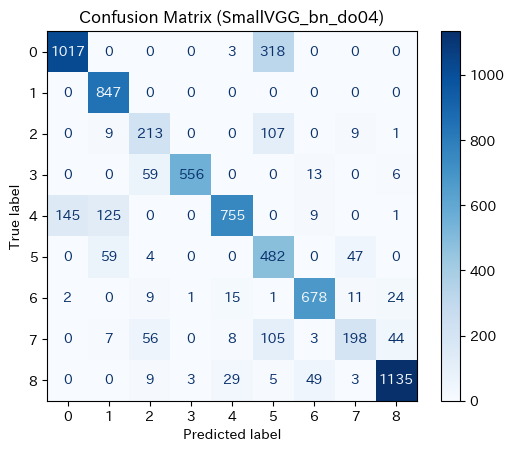

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
# model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
# model.load_state_dict(torch.load(best_model_path))
# model.to(device)
# model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9987
Test AUC: 0.9768


## 試行9：smallVGG + Batch Normalization を追加＋学習率スケジュール

In [48]:
class SmallVGG_bn_lr(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_bn_lr, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_bn_lr(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_bn_lr"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# スケジューラを定義
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # 5エポックごとに学習率を半分に
# 初期学習率を表示
print(f"Initial LR: {scheduler.get_last_lr()[0]:.6f}")

SmallVGG_bn_lr
Initial LR: 0.001000


In [49]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデルの保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at Epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break
            
    # スケジューラで学習率を更新
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}, Current LR: {current_lr:.6f}")

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    
# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0068, Train Acc: 0.6847
Val Loss: 0.0057, Val Acc: 0.7356
Best model saved at Epoch 1 with Val Loss: 0.0057
Epoch 1, Current LR: 0.001000
Epoch 2, Train Loss: 0.0038, Train Acc: 0.8319
Val Loss: 0.0031, Val Acc: 0.8602
Best model saved at Epoch 2 with Val Loss: 0.0031
Epoch 2, Current LR: 0.001000
Epoch 3, Train Loss: 0.0029, Train Acc: 0.8730
Val Loss: 0.0040, Val Acc: 0.8374
No improvement. Early stopping counter: 1/5
Epoch 3, Current LR: 0.001000
Epoch 4, Train Loss: 0.0023, Train Acc: 0.8961
Val Loss: 0.0105, Val Acc: 0.7298
No improvement. Early stopping counter: 2/5
Epoch 4, Current LR: 0.001000
Epoch 5, Train Loss: 0.0020, Train Acc: 0.9108
Val Loss: 0.0027, Val Acc: 0.8749
Best model saved at Epoch 5 with Val Loss: 0.0027
Epoch 5, Current LR: 0.000500
Epoch 6, Train Loss: 0.0016, Train Acc: 0.9282
Val Loss: 0.0023, Val Acc: 0.8920
Best model saved at Epoch 6 with Val Loss: 0.0023
Epoch 6, Current LR: 0.000500
Epoch 7, Train Loss: 0.0016, Train Acc: 0.9318

In [50]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_bn_lr
Val Loss: 0.0007
Model path: best_model_SmallVGG_bn_lr.pth
Test Loss: 0.0049, Test Accuracy: 0.8556


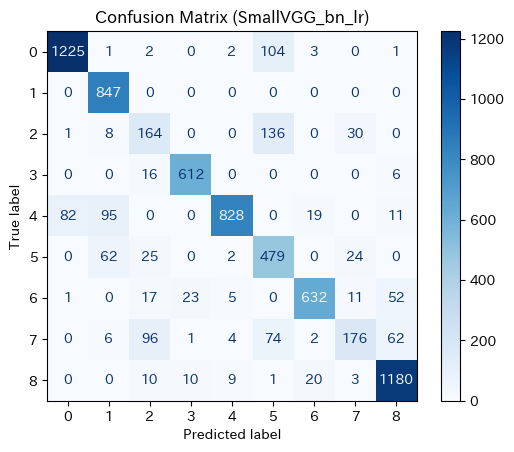

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
# model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
# model.load_state_dict(torch.load(best_model_path))
# model.to(device)
# model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9990
Test AUC: 0.9723


## 試行4-1：smallVGG + Dropout を畳み込みブロック後にBatch Normalization を追加

- 目的
過学習を抑制し、汎化性能を向上
- 変更点
各畳み込みブロックの後に Dropout を追加

In [53]:
n_epochs = 50
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [54]:
class SmallVGG_do(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_do, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(0.3),  # 過学習防止

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout(0.3)  # 過学習防止
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_do(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_do"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG_do


In [55]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0170, Train Acc: 0.1652
Val Loss: 0.0164, Val Acc: 0.2186
Best model saved for SmallVGG_do at Epoch 1
Epoch 2, Train Loss: 0.0142, Train Acc: 0.3034
Val Loss: 0.0127, Val Acc: 0.3809
Best model saved for SmallVGG_do at Epoch 2
Epoch 3, Train Loss: 0.0117, Train Acc: 0.4153
Val Loss: 0.0098, Val Acc: 0.5191
Best model saved for SmallVGG_do at Epoch 3
Epoch 4, Train Loss: 0.0092, Train Acc: 0.5459
Val Loss: 0.0083, Val Acc: 0.5910
Best model saved for SmallVGG_do at Epoch 4
Epoch 5, Train Loss: 0.0084, Train Acc: 0.5817
Val Loss: 0.0098, Val Acc: 0.5213
No improvement. Early stopping counter: 1/5
Epoch 6, Train Loss: 0.0078, Train Acc: 0.6094
Val Loss: 0.0074, Val Acc: 0.6344
Best model saved for SmallVGG_do at Epoch 6
Epoch 7, Train Loss: 0.0073, Train Acc: 0.6329
Val Loss: 0.0072, Val Acc: 0.6407
Best model saved for SmallVGG_do at Epoch 7
Epoch 8, Train Loss: 0.0070, Train Acc: 0.6510
Val Loss: 0.0064, Val Acc: 0.6868
Best model saved for SmallVGG_do at Epoch 8


In [56]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_do
Val Loss: 0.0017
Model path: best_model_SmallVGG_do.pth
Test Loss: 0.0050, Test Accuracy: 0.8153


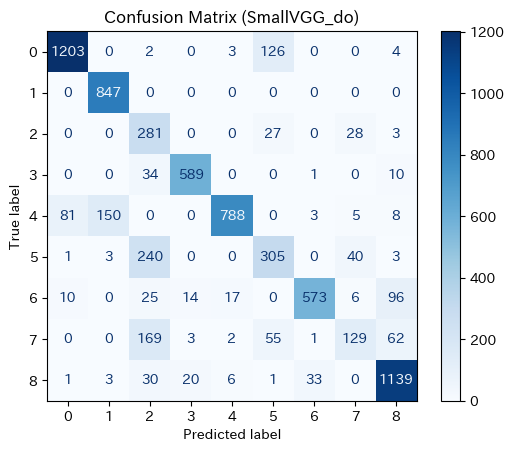

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
# model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
# model.load_state_dict(torch.load(best_model_path))
# model.to(device)
# model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9959
Test AUC: 0.9747


## 試行10：batchnormalizationと畳み込み層の後にdropout(0.3)を追加

In [60]:
n_epochs = 40
lr = 0.001
patience = 5

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [62]:
class SmallVGG_do_bn(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SmallVGG_do_bn, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(0.3),  # 過学習防止

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # 正規化
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout(0.3)   # 過学習防止
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),  # Flattenした特徴量を全結合層に入力
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # フラット化
        x = self.classifier(x)
        return x

model = SmallVGG_do_bn(in_channels=n_channels, num_classes=n_classes)
model.experiment_name = "SmallVGG_do_bn"
print(model.experiment_name)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

SmallVGG_do_bn


In [63]:
# Visdom 接続確認
viz = Visdom(server="http://host.docker.internal", port=8097)
assert viz.check_connection(), "Visdom サーバーが起動していません。"

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 初期化
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
best_val_loss = float('inf')
all_model_results = []  # 全体のベストモデルを記録するリスト
stopping_counter = 0

# モデル保存パス
best_model_path = f"best_model_{model.experiment_name}.pth"

# 学習ループ
for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 学習
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)

    # 検証
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device).squeeze()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)

    # Visdom可視化
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]),
             win=f'loss_{model.experiment_name}', name='avg_train_loss', update='append',
             opts={'title': f'Loss ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Loss'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_train_acc]),
             win=f'acc_{model.experiment_name}', name='avg_train_acc', update='append',
             opts={'title': f'Accuracy ({model.experiment_name})', 'xlabel': 'Epoch', 'ylabel': 'Accuracy'})

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_loss]),
             win=f'loss_{model.experiment_name}', name='avg_val_loss', update='append')

    viz.line(X=np.array([epoch]), Y=np.array([avg_val_acc]),
             win=f'acc_{model.experiment_name}', name='avg_val_acc', update='append')

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

    # ベストモデル保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"best_model_{model.experiment_name}.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved for {model.experiment_name} at Epoch {epoch+1}")

        stopping_counter = 0  # Early Stoppingリセット
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")
        if stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # 結果を保存
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# 全体のベストモデルを記録
all_model_results.append({
    "model_name": model.experiment_name,
    "val_loss": best_val_loss,
    "file_path": best_model_path
})

Setting up a new session...


Epoch 1, Train Loss: 0.0077, Train Acc: 0.6334
Val Loss: 0.0055, Val Acc: 0.7444
Best model saved for SmallVGG_do_bn at Epoch 1
Epoch 2, Train Loss: 0.0049, Train Acc: 0.7713
Val Loss: 0.0041, Val Acc: 0.8119
Best model saved for SmallVGG_do_bn at Epoch 2
Epoch 3, Train Loss: 0.0041, Train Acc: 0.8106
Val Loss: 0.0046, Val Acc: 0.8063
No improvement. Early stopping counter: 1/5
Epoch 4, Train Loss: 0.0035, Train Acc: 0.8413
Val Loss: 0.0036, Val Acc: 0.8358
Best model saved for SmallVGG_do_bn at Epoch 4
Epoch 5, Train Loss: 0.0030, Train Acc: 0.8641
Val Loss: 0.0034, Val Acc: 0.8443
Best model saved for SmallVGG_do_bn at Epoch 5
Epoch 6, Train Loss: 0.0026, Train Acc: 0.8830
Val Loss: 0.0026, Val Acc: 0.8774
Best model saved for SmallVGG_do_bn at Epoch 6
Epoch 7, Train Loss: 0.0023, Train Acc: 0.8959
Val Loss: 0.0024, Val Acc: 0.8892
Best model saved for SmallVGG_do_bn at Epoch 7
Epoch 8, Train Loss: 0.0021, Train Acc: 0.9066
Val Loss: 0.0017, Val Acc: 0.9246
Best model saved for Small

In [64]:
# 全体のベストモデルを選択
best_overall_model = min(all_model_results, key=lambda x: x["val_loss"])
print(f"Best overall model: {best_overall_model['model_name']}")
print(f"Val Loss: {best_overall_model['val_loss']:.4f}")
print(f"Model path: {best_overall_model['file_path']}")

# テストデータで性能確認
model.load_state_dict(torch.load(best_overall_model['file_path'], weights_only=True))
model.eval()

test_loss = 0
test_acc = 0
with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader.dataset)
avg_test_acc = test_acc / len(test_dataloader.dataset)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

Best overall model: SmallVGG_do_bn
Val Loss: 0.0006
Model path: best_model_SmallVGG_do_bn.pth
Test Loss: 0.0038, Test Accuracy: 0.8830


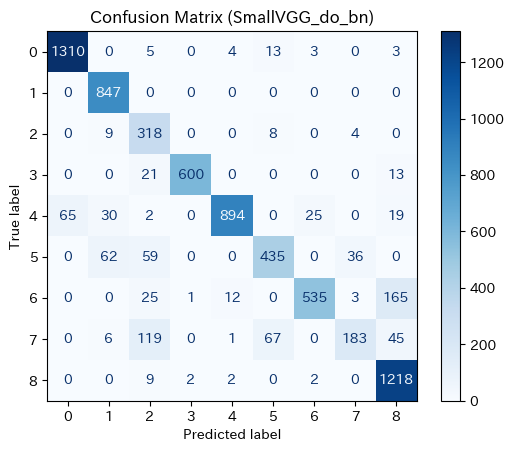

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ベストモデルをロード
# model = SmallVGG_3blocks(in_channels=n_channels, num_classes=n_classes)
# model.load_state_dict(torch.load(best_model_path))
# model.to(device)
# model.eval()

# テストデータで予測
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 混同行列を計算
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({model.experiment_name})")
plt.show()

In [66]:
from sklearn.metrics import roc_auc_score

# 検証データでAUCを計算する関数
def calculate_auc(model, dataloader, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # モデルの出力を取得（Softmaxで確率に変換）
            outputs = model(imgs)
            probabilities = torch.softmax(outputs, dim=1)

            # 正解ラベルとスコアを収集
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probabilities.cpu().numpy())

    # AUCを計算（多クラスの場合: "ovr"）
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr")  # 多クラス分類の場合
    return auc

# 検証データでAUCを計算
val_auc = calculate_auc(model, val_dataloader, device)
print(f"Validation AUC: {val_auc:.4f}")

# テストデータでAUCを計算
test_auc = calculate_auc(model, test_dataloader, device)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC: 0.9994
Test AUC: 0.9852
